<h1 style = "text-align:center; font-family:courier; font-size:250%; color:yellow ; border: 1px solid; padding: 40px;" >
    <em>Spam Detection with Naive Bayes</em>
</h1>

####    ***In this project, we build a spam classifier using machine learning techniques. We use a labeled SMS dataset to detect whether a given message is spam or not. The process involves data cleaning, text preprocessing, feature extraction using TF-IDF, training a Naive Bayes model, evaluating the performance, and applying techniques to improve results.***

<hr style = " border-top: 2px solid purple; " />

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

<hr style = " border-top: 2px solid purple; " />

#### ***We use a public SMS Spam dataset from Kaggle. First, we inspect the data to understand its structure, the types of columns, and check for missing or irrelevant values.*** ####   

<hr style = " border-top: 2px solid purple; " />

In [2]:
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv',encoding='latin-1')
df.head().T

,0,1,2,3,4
v1,ham,ham,spam,ham,ham
v2,"Go until jurong point, crazy.. Available only ...",Ok lar... Joking wif u oni...,Free entry in 2 a wkly comp to win FA Cup fina...,U dun say so early hor... U c already then say...,"Nah I don't think he goes to usf, he lives aro..."
Unnamed: 2,NaN,NaN,NaN,NaN,NaN
Unnamed: 3,NaN,NaN,NaN,NaN,NaN
Unnamed: 4,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df.describe().T

,count,unique,top,freq
v1,5572,2,ham,4825
v2,5572,5169,"Sorry, I'll call later",30
Unnamed: 2,50,43,"bt not his girlfrnd... G o o d n i g h t . . .@""",3
Unnamed: 3,12,10,"MK17 92H. 450Ppw 16""",2
Unnamed: 4,6,5,"GNT:-)""",2


<hr style = " border-top: 2px solid purple; " />

#### ***We drop unnecessary columns that contain null or irrelevant values and keep only the columns required for classification: the label (spam or ham) and the message text.***

<hr style = " border-top: 2px solid purple; " />

In [5]:
df = df[['v1','v2']]
df.columns = ['label','message']
df.head().T

,0,1,2,3,4
label,ham,ham,spam,ham,ham
message,"Go until jurong point, crazy.. Available only ...",Ok lar... Joking wif u oni...,Free entry in 2 a wkly comp to win FA Cup fina...,U dun say so early hor... U c already then say...,"Nah I don't think he goes to usf, he lives aro..."


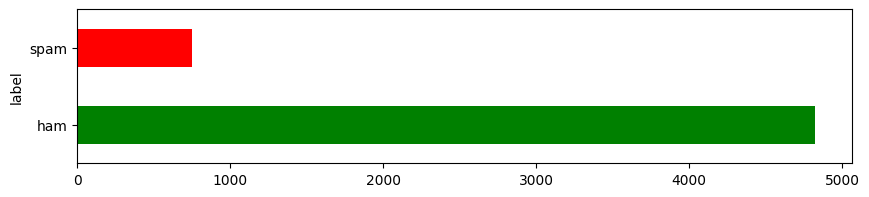

In [6]:
# Visualize the distribution of spam and ham messages
plt.figure(figsize=(10, 2))
df['label'].value_counts().plot(kind='barh',color=['green','red'])
plt.title = 'Distribution of Spam vs Ham'
plt.xlabel = 'Label'
plt.show()

<hr style = " border-top: 2px solid purple; " />

#### ***Before feeding the text to the model, we clean it using techniques like:***
##### - Lowercasing all text
##### - Removing punctuation and non-alphanumeric characters
##### - Removing stopwords
##### - Applying stemming

#### ***This helps reduce noise and improve model performance.*** ####

<hr style = " border-top: 2px solid purple; " />

In [7]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

In [8]:
# Define a function to preprocess text data
def preprocess_text(text):
  text = text.lower()
  text = re.sub(r'[^a-zA-Z0-9\s]','',text)
  text = ' '.join([ps.stem(word) for word in text.split() if word not in stop_words])
  return text

In [9]:
df['processed_message'] = df['message'].apply(preprocess_text)
df.head().T

,0,1,2,3,4
label,ham,ham,spam,ham,ham
message,"Go until jurong point, crazy.. Available only ...",Ok lar... Joking wif u oni...,Free entry in 2 a wkly comp to win FA Cup fina...,U dun say so early hor... U c already then say...,"Nah I don't think he goes to usf, he lives aro..."
processed_message,go jurong point crazi avail bugi n great world...,ok lar joke wif u oni,free entri 2 wkli comp win fa cup final tkt 21...,u dun say earli hor u c alreadi say,nah dont think goe usf live around though


In [10]:
X = df['processed_message']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<hr style = " border-top: 2px solid purple; " />

#### ***We convert text data into numerical form using TF-IDF vectorization. TF-IDF helps us find which words are important in a specific message while reducing the weight of common words across all messages.***

<hr style = " border-top: 2px solid purple; " />

In [11]:
# Convert text messagesinto numericalfeatures using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

<hr style = " border-top: 2px solid purple; " />

#### ***We use the Multinomial Naive Bayes classifier, which is well-suited for text classification tasks and train the model on the training set and prepare it for evaluation. After that we evaluate the model using classification metrics such as accuracy, precision, recall, and F1-score. A confusion matrix is also used to visually inspect how well the model distinguishes between spam and ham.***

<hr style = " border-top: 2px solid purple; " />

Accuracy: 0.9623318385650225
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



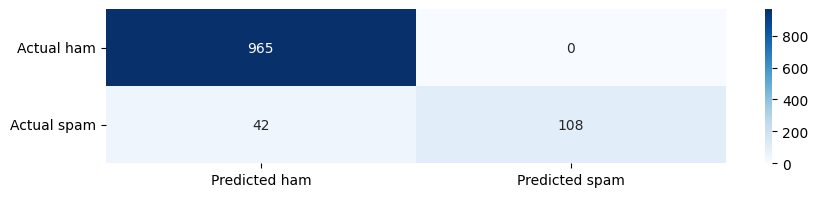

In [12]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

y_pred = nb_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted ham', 'Predicted spam'],
            yticklabels=['Actual ham', 'Actual spam'])
plt.show()

<hr style = " border-top: 2px solid purple; " />

#### ***We use GridSearchCV to find the best parameters (like alpha and fit_prior) for the Naive Bayes model to improve the classification results.***

<hr style = " border-top: 2px solid purple; " />

Best Parameters: {'alpha': 0.1, 'fit_prior': True}
Best Cross-Validation Score: 0.9505502815518121
Test Accuracy: 0.9829596412556054
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       1.00      0.87      0.93       150

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



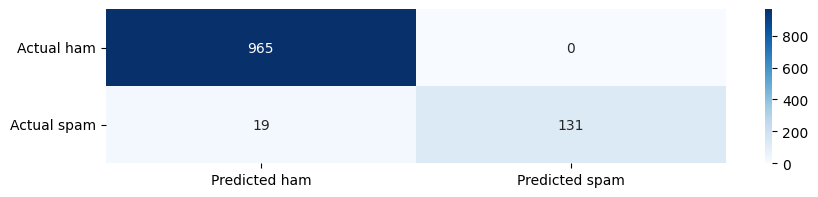

In [13]:
# Tiuning parameters
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'fit_prior': [True, False]
}

# Using GridSearchCV for tiuning the model
grid_search = GridSearchCV(estimator=nb_classifier,
                           param_grid=param_grid, cv=5,
                           scoring='f1_macro', n_jobs=-1)


# Fit the GridSearchCV to the training data
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted ham', 'Predicted spam'],
            yticklabels=['Actual ham', 'Actual spam'])
plt.show()


<hr style = " border-top: 2px solid purple; " />


#### ***In this project, we successfully built a spam detection model using the Multinomial Naive Bayes algorithm. After preprocessing the data and tuning hyperparameters, we achieved a recall score of 87% for spam messages, which shows the model is effective in identifying spam.While we explored additional techniques like SMOTE and enhanced preprocessing, we found that they didn't improve performance further in this case. Future improvements could include trying other classifiers, larger datasets, or deep learning methods.***
#### ***Overall, this project demonstrates a full machine learning pipeline for a real-world NLP problem.***
